## Import Libraries
**Note: Please include a `requirements.txt` file in the future**

In [3]:
import pandas as pd
import numpy as np
import os
import re
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
from transformers import BertTokenizer
from torchvision import transforms
import torchvision.transforms.functional as F 
from torchvision.models import vgg16

from PIL import Image
import matplotlib.pyplot as plt

from transformers import BertModel, BertTokenizer

import warnings
warnings.filterwarnings('ignore') 

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    print("No GPU found")
device

device(type='mps')

## Part 1.

### Read in the data
**Note: move the `results.csv` file into the cloned repository and the below cell will run**

1. We want to have two versions `data_raw` will be the untouched dataset and `data_copy` will be the one we do manipulations on 
    

In [6]:
data_raw = pd.read_csv(f"{os.getcwd()}/results.csv",
                       delimiter="|")
data_copy = data_raw

### Data cleaning and info
1. Call .info() to generate the non-null counts, the column name, and the data type of each column
    - There is whitespace in `comment_number` and `comment` column names
    - There is a null value in the `comment` column
2. Verify there is 5 comments for each image
3. Call .describe() to generate basic statistics about the data
    - There is one more unique comment number in the `comment_number` column

In [7]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   image_name       158915 non-null  object
 1    comment_number  158915 non-null  object
 2    comment         158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [8]:
print("Before cleaning: ", data_copy.columns)
data_copy.columns = data_copy.columns.str.replace(' ', '')
print("After cleaning: ", data_copy.columns)

Before cleaning:  Index(['image_name', ' comment_number', ' comment'], dtype='object')
After cleaning:  Index(['image_name', 'comment_number', 'comment'], dtype='object')


The data is structured into three columns:
1. **image_name**: represents the image that the comments are attached to
2. **comment_number**: the comment number associated with the image
3. **comment**: the actual comment of the image

We should expect to see 5 comments for each image

In [9]:
image_name_unique_vals = data_copy['image_name'].unique().tolist()
print("Total length of unique values: ", len(image_name_unique_vals))
print("Total length of data frame: ",  len(data_raw))
print("Total length of unique values with comments:", len(image_name_unique_vals) * 5)

Total length of unique values:  31783
Total length of data frame:  158915
Total length of unique values with comments: 158915


In [10]:
data_copy.describe(include='all').transpose()

,count,unique,top,freq
image_name,158915,31783,1000092795.jpg,5
comment_number,158915,6,0,31783
comment,158914,158438,Two dogs playing in the snow .,7


In [11]:
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
comment_number_unique_vals

[' 0', ' 1', ' 2', ' 3', ' 4', ' 4   A dog runs across the grass .']

In [12]:
data_copy['comment_number'] = data_copy['comment_number'].str.replace('\s+', '', regex=True)
comment_number_unique_vals = data_copy['comment_number'].unique().tolist()
comment_number_unique_vals

['0', '1', '2', '3', '4', '4Adogrunsacrossthegrass.']

In [13]:
data_copy[data_copy.isnull().any(axis=1)]

,image_name,comment_number,comment
19999,2199200615.jpg,4Adogrunsacrossthegrass.,NaN


In [14]:
data_copy.loc[19999, 'image_name'] = '2199200615.jpg'
data_copy.loc[19999, 'comment_number'] = '4'
data_copy.loc[19999, 'comment'] = 'A dog runs across the grass.'
data_copy.iloc[19999]

image_name                      2199200615.jpg
comment_number                               4
comment           A dog runs across the grass.
Name: 19999, dtype: object

### Feature Engineering
1. Preprocess text and make a new column with cleaned text
    - Remove whitespace
    - Remove punctuation
    - Expand contractions
    - Make everything lowercase
    - Remove stopwords
    - Lemmatize words that are needed
2. Encode text for BERT
    - Get the max length of the comments in the dataset
    - Generate the input_ids and the attention masks for each comment in the dataset
        - Add these as columns into the dataset
3. Preprocess images
    - Turn each image path into a column in the dataset
    - Resize each image to (224 x 224)
    - Use a standard mean and std 
    - Turn each image to a tensor
4. Get VGG16 embeddings
    - Extract the classifiaction layer from vgg16
    - Take the first 500 rows -> 100 images
    - Put the embeddings in a new column
5. Get BERT embeddings

In [15]:
data_copy = data_copy[:50]

#### Preprocess Text
1. Remove whitespace from each comment
2. Remove all punctuations from each comment
3. Expand contractions 
4. Turn all comments to lower case
5. Tokenize each word -> i.e. turn comment into a list of substrings for each word
    - comment: "I like dogs" -> ['I', 'like', 'dogs']
6. Use the tokenizing of the words to remove `stopwords`
    - A `stopword` is a common occuring word. Words such as 'a' and 'is' are examples of a `stopword`
    - Get a set of English stopwords to remove common words like 'the', 'is', etc.
7. Lemmatize the words
    - A `lemmatizer` takes a word and turns it into its lemma
    - For example, if we have the words 'walking', 'walked' and 'walks' the words would now become 'walk'

8. Return the comment
    - Each comment is turned into its own string and returned

In [17]:
def process_comment(comment):
    '''
    Preprocess the ith row and jth comment
    
    @comment: the comment that is getting preprocessed
    '''
    comment = comment.strip()
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    comment = contractions.fix(comment)
    comment = comment.lower()
    words = word_tokenize(comment)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    processed_comment = ' '.join(words)
    return processed_comment

In [18]:
data_copy['cleaned_comment'] = data_copy['comment'].apply(process_comment)
data_copy.sample(1)

,image_name,comment_number,comment,cleaned_comment
33,1000919630.jpg,3,A man holds a large stuffed lion toy .,man hold large stuffed lion toy


#### Encode Text for BERT
1. Getting the max length of the comments
    1. Grab all the comments and store them into a numpy array
        - We can do this by using `.values` on a column of a pandas df
            - array[('A dog', 'A cat')]
    2. `Tokenize` each word
        - The `NLTK tokenizer` turns each comment into a sublist of words of the entire comment
        - The `BERT tokenizer` turns each word inside of a comment to its own unique integer
            - There are special tokens called `cls`, `sep`, `unk`, `pad`, `mask`
                - `cls`: tells us when the sentence begins
                - `sep`: tells us when the sentence ends
                - `unk`: tells us when a word is not in BERT's vocabulary
                - `pad`: tells us when a sentence is too short, so we add this token to make it longer
                - `mask`: masks a word in the sentence and tries to get the model to predict the word during training
   3. Loop through the comments, tokenize each comment, and find the max length of all the sentences because we need to pad the other sentences to this length as an input for the model

In [19]:
sentences = data_copy['cleaned_comment'].values

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [21]:
max_len = 0
for i in sentences:
    input_ids = tokenizer.encode(i, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
max_len

17

In [22]:
def gen_ids_masks(text, max_len=64):
    tokens = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt',
    )
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    return input_ids, attention_mask

In [23]:
data_copy['input_ids'], data_copy['attention_mask'] = zip(*data_copy['cleaned_comment'].apply(gen_ids_masks))
data_copy.head()

,image_name,comment_number,comment,cleaned_comment,input_ids,attention_mask
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guy shaggy hair look hand hanging yard,"[[tensor(101), tensor(2048), tensor(2402), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,1000092795.jpg,1,"Two young , White males are outside near many...",two young white male outside near many bush,"[[tensor(101), tensor(2048), tensor(2402), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,two men green shirt standing yard,"[[tensor(101), tensor(2048), tensor(2273), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,man blue shirt standing garden,"[[tensor(101), tensor(2158), tensor(2630), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,1000092795.jpg,4,Two friends enjoy time spent together .,two friend enjoy time spent together,"[[tensor(101), tensor(2048), tensor(2767), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


#### Vgg16 Embeddings

In [24]:
image_root_path = f"{os.getcwd()}/flickr30k_images/"
data_copy['image_path'] = image_root_path + data_copy['image_name']
data_copy.sample(1)

,image_name,comment_number,comment,cleaned_comment,input_ids,attention_mask,image_path
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,man blue shirt standing garden,"[[tensor(101), tensor(2158), tensor(2630), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",/Users/blakedickerson/image-text-retrieval/fli...


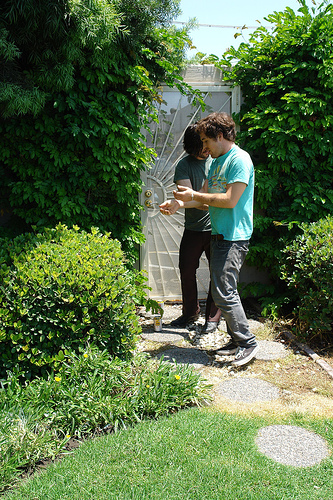

In [25]:
image_path = data_copy.at[0, 'image_path']
img = Image.open(image_path)
display(img)

In [26]:
data_copy['vgg16_embeddings'] = None

# Create vgg16 model from torchvision and put on GPU
vgg16 = vgg16(pretrained=True).to(device)
# Get the embeddings by removing the classification layer
vgg16 = torch.nn.Sequential(*(list(vgg16.children())[:-1]))
# Put in train mode
vgg16.eval()

# Preprocess images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# Loop over dataset and train on model
with torch.no_grad():
    for idx in range(len(data_copy)):
        image_path = data_copy.at[idx, 'image_path']
        img = Image.open(image_path).convert('RGB')
        # Add a batch to the image -> [C, H, W] -> [1, C, H, W]
        img_tensor = transform(img).unsqueeze(dim=0).to(device)
        embeddings = vgg16(img_tensor)
        data_copy.at[idx, 'vgg16_embeddings'] = embeddings.cpu().numpy()

In [27]:
data_copy.head(1)

,image_name,comment_number,comment,cleaned_comment,input_ids,attention_mask,image_path,vgg16_embeddings
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guy shaggy hair look hand hanging yard,"[[tensor(101), tensor(2048), tensor(2402), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",/Users/blakedickerson/image-text-retrieval/fli...,[[[[1.3359709 1.5480984 1.9950091 1.369992 0....


#### BERT Embeddings
1. Instantiate the pre-trained BERT model and set the training to the GPU using `.to(device)`
2. Fine-tune the BERT pre-trained model over the comments
    1. Make a new column for the BERT embeddings and set all values to null
    2. Loop over the dataset
        - Use `torch.no_grad()` because we do not need gradient calculations because we do not need any backpropogation since we do not need a loss function, rather just the embeddings
        - Get the input ids at the $i^{th}$ and $j^{th}$ row and column, respectively
        - Get the attention mask at the $i^{th}$ and $j^{th}$ row and column, respectively
        - Get the output of the BERT model using the inputs `input ids` and `attention mask`
        - Get the embeddings, which is the last state of the output

In [28]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [29]:
input_ids_column = 'input_ids'
attention_mask_column = 'attention_mask'
data_copy['bert_embeddings'] = None


with torch.no_grad():
    for idx in range(len(data_copy)):
        input_ids = data_copy.at[idx, input_ids_column].to(device)
        attention_mask = data_copy.at[idx, attention_mask_column].to(device)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        data_copy.at[idx, 'bert_embeddings'] = embeddings.cpu().numpy()

In [30]:
data_copy.head(1)

,image_name,comment_number,comment,cleaned_comment,input_ids,attention_mask,image_path,vgg16_embeddings,bert_embeddings
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,two young guy shaggy hair look hand hanging yard,"[[tensor(101), tensor(2048), tensor(2402), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",/Users/blakedickerson/image-text-retrieval/fli...,[[[[1.3359709 1.5480984 1.9950091 1.369992 0....,"[[[-0.2685596, 0.21052477, -0.08599222, -0.265..."


## Part 2. 
In this part we will build two graphs, x & y, respectively, where each node is an image and each edge is determined by its similarity with the node

### Step 2.1 

In [31]:
test = data_copy

In [28]:
grouped_df = test.groupby('image_name')['bert_embeddings'].mean().reset_index()
grouped_df

,image_name,bert_embeddings
0,1000092795.jpg,"[[[-0.17085436, 0.013257119, -0.13085243, -0.0..."
1,10002456.jpg,"[[[-0.19248256, 0.318976, -0.2603562, 0.016116..."
2,1000268201.jpg,"[[[-0.62744063, -0.051850475, -0.27312058, 0.1..."
3,1000344755.jpg,"[[[-0.18688877, 0.296542, -0.1446671, -0.03153..."
4,1000366164.jpg,"[[[-0.3103027, 0.282773, -0.43642926, 0.020891..."
5,1000523639.jpg,"[[[-0.43107438, -0.0103414655, -0.52872574, 0...."
6,1000919630.jpg,"[[[-0.7743735, 0.005677332, -0.46635753, 0.063..."
7,10010052.jpg,"[[[-0.48672423, -0.051622212, -0.18541262, 0.1..."
8,1001465944.jpg,"[[[-0.14205135, 0.13404062, -0.09045594, -0.11..."
9,1001545525.jpg,"[[[-0.38474017, -0.012998248, -0.3832542, 0.20..."


In [29]:
bert_embedding_arrays = grouped_df['bert_embeddings'].apply(lambda x: np.array(x).flatten())
bert_embedding_arrays = np.array(bert_embedding_arrays.tolist())
bert_embedding_arrays.shape

(10, 49152)